In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import re
from nltk.corpus import stopwords
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
os.chdir('C:/Users/Admin/Desktop')

In [2]:
data=pd.read_csv('training_variants')
print(data.shape[0])
print(data.shape[1])

3321
4


In [3]:
data_text=pd.read_csv('training_text',sep='\|\|',engine='python',names=['ID','TEXT'],skiprows=1)
print(data_text.shape[0])
print(data_text.shape[1])

3321
2


In [4]:
stop_words=set(stopwords.words('english'))

def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string=""
        total_text=re.sub('[^a-zA-Z0-9\n]',' ',total_text)
        total_text=re.sub('\s+',' ',total_text)
        total_text=total_text.lower()
        for word in total_text.split():
            if word not in stop_words:
                string+=word+" "
    data_text[column][index]=string            

In [5]:
for index,row in data_text.iterrows():
    if(type(row['TEXT'])) is str:
        nlp_preprocessing(row['TEXT'],index,'TEXT')
    else:
        print(index)

<ipython-input-4-2afe5d2c2aa8>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text[column][index]=string


1109
1277
1407
1639
2755


In [6]:
result=pd.merge(data,data_text,how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [7]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [8]:
result.loc[result['TEXT'].isnull(),'TEXT']=result['Gene']+' '+result['Variation']

In [9]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [10]:
y_true=result['Class'].values

In [11]:
result.Gene=result.Gene.str.replace('\s+','_')
result.Variation=result.Variation.str.replace('\s+','_')

In [12]:
X_train,test_df,y_train,y_test=train_test_split(result,y_true,stratify=y_true,test_size=0.2)
train_df,cv_df,y_train,y_cv=train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

In [13]:
print(train_df.shape[0])
print(cv_df.shape[0])
print(test_df.shape[0])

2124
532
665


In [14]:
train_class_distribution=train_df['Class'].value_counts()
cv_class_distribution=cv_df['Class'].value_counts()
test_class_distribution=test_df['Class'].value_counts()

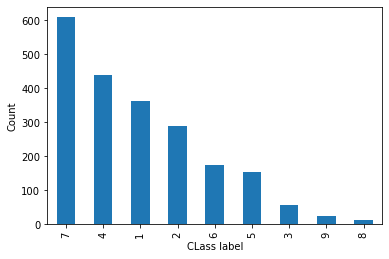

In [15]:
train_class_distribution.plot(kind='bar')
plt.xlabel('CLass label')
plt.ylabel('Count')
plt.show()

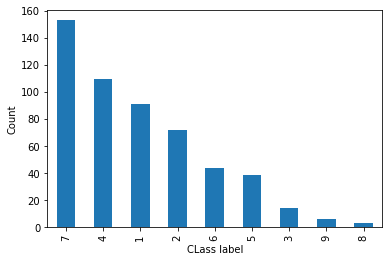

In [16]:
cv_class_distribution.plot(kind='bar')
plt.xlabel('CLass label')
plt.ylabel('Count')
plt.show()

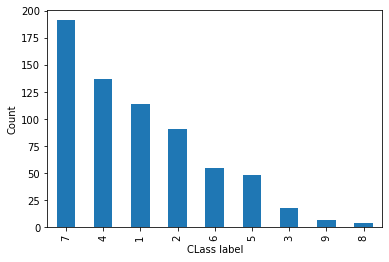

In [17]:
test_class_distribution.plot(kind='bar')
plt.xlabel('CLass label')
plt.ylabel('Count')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
import seaborn as sns
def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)
    
    A=(((C.T)/(C.sum(axis=1)))).T
    B=(C/C.sum(axis=0))
    
    labels=[1,2,3,4,5,6,7,8,9]
    print("confusion_matrix")
    sns.heatmap(C,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted values')
    plt.ylabel('actual values')
    plt.show()
    
    
    print("Precision matrix")
    sns.heatmap(B,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted values')
    plt.ylabel('actual values')
    plt.show()
    
    print("Recall matrix")
    sns.heatmap(A,annot=True,cmap="YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('predicted values')
    plt.ylabel('actual values')
    plt.show()
    
    
    
    

D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [19]:
test_data_len=test_df.shape[0]
cv_data_len=cv_df.shape[0]

In [20]:
cv_predict_y=np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs=np.random.rand(1,9)
    cv_predict_y[i]=(rand_probs/sum(sum(rand_probs)))[0]
print(log_loss(y_cv,cv_predict_y,eps=1e-15))    

2.4776986159620096


In [21]:
test_predict_y=np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs=np.random.rand(1,9)
    test_predict_y[i]=(rand_probs/sum(sum(rand_probs)))[0]
print(log_loss(y_test,test_predict_y,eps=1e-15))    

2.4819338427445117


confusion_matrix


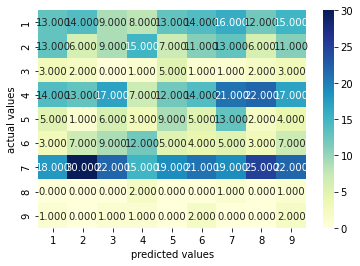

Precision matrix


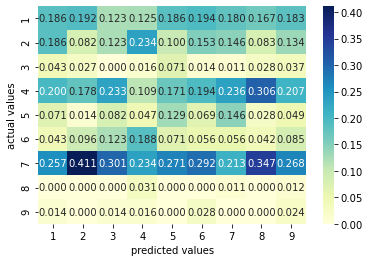

Recall matrix


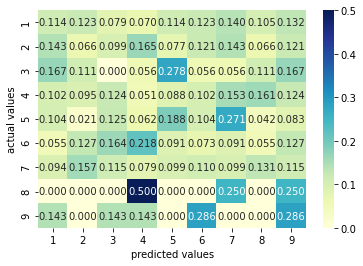

In [22]:
predicted_y=np.argmax(test_predict_y,axis=1)
plot_confusion_matrix(y_test,predicted_y+1)

In [23]:
def get_gv_dict(alpha,feature,df):
    value_count=train_df[feature].value_counts()
    gv_dict=dict()
    for i,denominator in value_count.items():
        vec=[]
        for k in range(1,10):
            cls_cnt=train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0]+alpha*10)/(denominator+90*alpha))
        gv_dict[i]=vec
    return  gv_dict    
    

In [24]:
def get_gv_feature(alpha,feature,df):
    gv_dict=get_gv_dict(alpha,feature,df)
    value_count=train_df[feature].value_counts()
    gv_fea=[]
    for index,row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea        

In [25]:
unique_game=train_df['Gene'].value_counts()
print(unique_game.head(2))

BRCA1    172
TP53     108
Name: Gene, dtype: int64


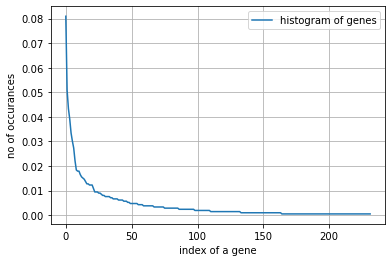

In [26]:
s=sum(unique_game.values)
h=unique_game.values/s
plt.plot(h,label='histogram of genes')
plt.xlabel('index of a gene')
plt.ylabel('no of occurances')
plt.legend()
plt.grid()
plt.show()

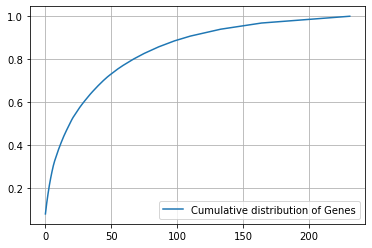

In [27]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

In [28]:
alpha=1
train_gen_response_coding=np.array(get_gv_feature(alpha,'Gene',train_df))
cv_gen_response_coding=np.array(get_gv_feature(alpha,'Gene',cv_df))
test_gen_response=np.array(get_gv_feature(alpha,'Gene',test_df))

In [29]:
print(train_gen_response_coding)

[[0.06493506 0.27922078 0.06493506 ... 0.25974026 0.06493506 0.06493506]
 [0.14736842 0.10526316 0.10526316 ... 0.10526316 0.10526316 0.11578947]
 [0.11458333 0.11458333 0.10416667 ... 0.125      0.10416667 0.10416667]
 ...
 [0.11111111 0.1010101  0.1010101  ... 0.1010101  0.1010101  0.1010101 ]
 [0.10280374 0.12149533 0.09345794 ... 0.17757009 0.10280374 0.09345794]
 [0.10638298 0.11702128 0.10638298 ... 0.13829787 0.10638298 0.10638298]]


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
gene_vectorizer=CountVectorizer()
train_gen_onehot_coding=gene_vectorizer.fit_transform(train_df['Gene'])
cv_gen_onehot_coding=gene_vectorizer.fit_transform(cv_df['Gene'])
test_gen_onhot_coding=gene_vectorizer.fit_transform(test_df['Gene'])

In [31]:
gene_vectorizer.get_feature_names()

['abl1',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'ar',
 'araf',
 'arid5b',
 'atrx',
 'aurka',
 'b2m',
 'bap1',
 'bcl10',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brip1',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'cdh1',
 'cdk12',
 'cdk6',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'chek2',
 'crebbp',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'flt3',
 'foxa1',
 'foxp1',
 'gnas',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'inpp4b',
 'jak1',
 'jak2',
 'kdm5c',
 'kdr',
 'keap1',
 'kit',
 'kmt2a',
 'kmt2c',
 'kmt2d',
 'knstrn',
 'kras',
 'lats1',
 'map2k1',
 'map2k2',
 'map2k4',
 'map3k1',
 'mef2b',
 'met',
 'mlh1',
 'msh2',
 'msh6',
 'mtor',
 'myc',
 'ncor1',
 'nf1',
 'nf2',
 'nfe2l2',
 'nfkbia',
 'notch1',
 'notch2',
 'nras',
 'ntrk1',
 'ntrk3',
 'pbrm1',
 'pdgf

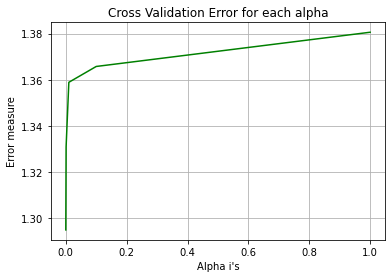

For values of best alpha =  1e-05 The train log loss is: 1.182085601934142
For values of best alpha =  1e-05 The cross validation log loss is: 1.2949393657093682
For values of best alpha =  1e-05 The test log loss is: 1.243570126910718


In [32]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf=SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gen_response_coding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gen_response_coding,y_train)
    predict_y=sig_clf.predict_proba(cv_gen_response_coding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))

plt.plot(alpha, cv_log_error_array,c='g')
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gen_response_coding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gen_response_coding, y_train)

predict_y = sig_clf.predict_proba(train_gen_response_coding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gen_response_coding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gen_response)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [33]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
print((test_coverage/test_df.shape[0])*100)
print((cv_coverage/cv_df.shape[0])*100)

97.29323308270676
95.30075187969925


In [34]:
unique_variations=train_df['Variation'].value_counts()
print(unique_variations.head(10))

Truncating_Mutations    58
Deletion                47
Amplification           44
Fusions                 19
Overexpression           5
T58I                     3
Q61R                     2
Q209L                    2
G13C                     2
C618R                    2
Name: Variation, dtype: int64


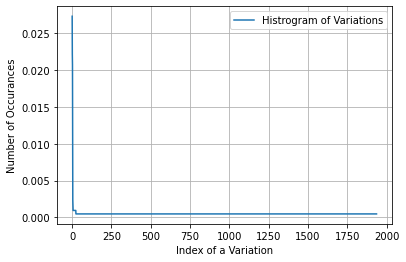

In [35]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02730697 0.04943503 0.07015066 ... 0.99905838 0.99952919 1.        ]


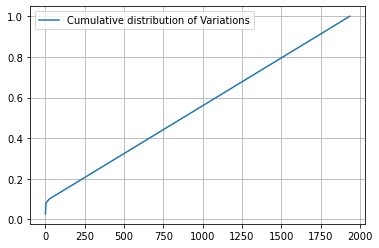

In [36]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [37]:
alpha=1

train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

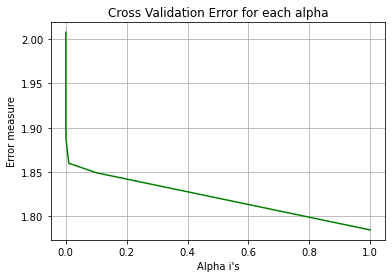

For values of best alpha =  1 The train log loss is: 1.0301477201741234
For values of best alpha =  1 The cross validation log loss is: 1.7843943461198883
For values of best alpha =  1 The test log loss is: 1.797430272217977


In [38]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf=SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_responseCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_responseCoding,y_train)
    predict_y=sig_clf.predict_proba(cv_variation_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))

plt.plot(alpha, cv_log_error_array,c='g')
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [44]:
from collections import defaultdict 
def extract_dict_paddle(df):
    dictionary=defaultdict(int)
    for index,row in df.iterrows():
        for word in row['TEXT'].split():
            dictionary[word]=dictionary[word]+1
    return dictionary       
    

In [59]:
import math
def get_text_responseCoding(df):
    x = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            x[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return x
    

In [51]:
dict_list=[]
for i in range(1,10):
    cls_text=train_df[train_df['Class']==i]
    dict_list.append(extract_dict_paddle(cls_text))
total_dict=extract_dict_paddle(cls_text)

    

In [60]:
train_text_feature_responseCoding  = get_text_responseCoding(train_df)
test_text_feature_responseCoding  = get_text_responseCoding(test_df)
cv_text_feature_responseCoding  = get_text_responseCoding(cv_df)

In [61]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

For values of alpha =  1e-05 The log loss is: 1.182042790803008
For values of alpha =  0.0001 The log loss is: 1.2158515099827094
For values of alpha =  0.001 The log loss is: 1.3549087323984434
For values of alpha =  0.01 The log loss is: 1.4052194209598952
For values of alpha =  0.1 The log loss is: 1.419047884064397
For values of alpha =  1 The log loss is: 1.4311728428514066


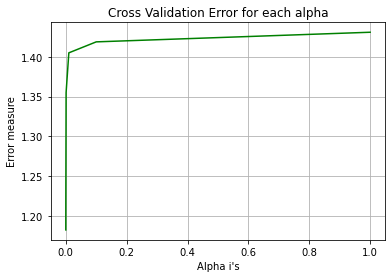

For values of best alpha =  1e-05 The train log loss is: 0.8754458238040972
For values of best alpha =  1e-05 The cross validation log loss is: 1.182042790803008
For values of best alpha =  1e-05 The test log loss is: 1.1235705415654433


In [63]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_responseCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_responseCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
plt.plot(alpha, cv_log_error_array,c='g')
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_responseCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_responseCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [79]:

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [67]:
train_gene_var_responseCoding = np.hstack((train_gen_response_coding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gen_response,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gen_response_coding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

for alpha = 1e-05
Log Loss : 1.2570194712323388
for alpha = 0.0001
Log Loss : 1.2570226708028194
for alpha = 0.001
Log Loss : 1.2570544170875837
for alpha = 0.1
Log Loss : 1.258985587864418
for alpha = 1
Log Loss : 1.2607383206302076
for alpha = 10
Log Loss : 1.304769292568419
for alpha = 100
Log Loss : 1.3137706257926245
for alpha = 1000
Log Loss : 1.317547829678709


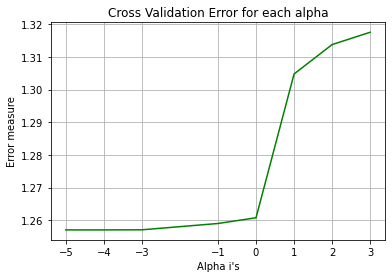

For values of best alpha =  1e-05 The train log loss is: 1.196420371452934
For values of best alpha =  1e-05 The cross validation log loss is: 1.2570194712323388
For values of best alpha =  1e-05 The test log loss is: 1.2306740351648822


In [72]:
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_responseCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding,y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

plt.plot(np.log10(alpha), cv_log_error_array,c='g')
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_responseCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding,y_train)



predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [75]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_responseCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding,y_train)
sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
print("Log Loss :",log_loss(y_cv, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_responseCoding)-y_cv))/y_cv.shape[0])


Log Loss : 1.2570194712323388
Number of missclassified point : 0.4492481203007519


for alpha = 5
Log Loss : 1.0463092590842336
for alpha = 11
Log Loss : 1.0506260950199102
for alpha = 15
Log Loss : 1.0623711306551022
for alpha = 21
Log Loss : 1.0763065246515549
for alpha = 31
Log Loss : 1.087266127981737
for alpha = 41
Log Loss : 1.088080829393417
for alpha = 51
Log Loss : 1.0966338949048378
for alpha = 99
Log Loss : 1.1013416465476373


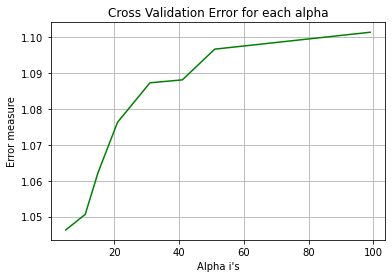

For values of best alpha =  5 The train log loss is: 0.4577501611255203
For values of best alpha =  5 The cross validation log loss is: 1.0463092590842336
For values of best alpha =  5 The test log loss is: 1.0247560915074942


In [78]:
from sklearn.neighbors import KNeighborsClassifier
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding,y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 
    
plt.plot(alpha, cv_log_error_array,c='g')
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding,y_train)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 1.0463092590842336
Number of mis-classified points : 0.34398496240601506
confusion_matrix


<ipython-input-18-80816488225b>:8: RuntimeWarning: invalid value encountered in true_divide
  B=(C/C.sum(axis=0))


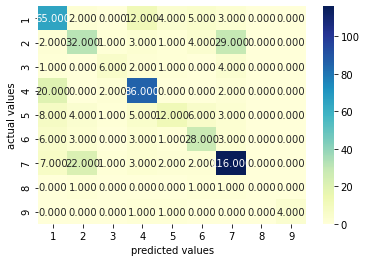

Precision matrix


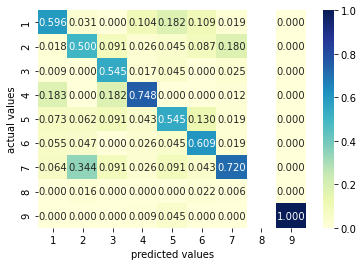

Recall matrix


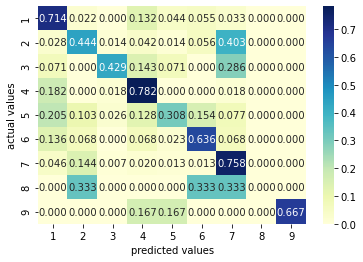

In [81]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding,y_train,cv_x_responseCoding,y_cv, clf)

In [86]:
from collections import Counter
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding,y_train)


test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", y_test[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(y_train[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 6
The  5  nearest neighbours of the test points belongs to classes [7 2 7 7 7]
Fequency of nearest points : Counter({7: 4, 2: 1})


for alpha = 1e-06
Log Loss : 1.1916356173962943
for alpha = 1e-05
Log Loss : 1.1005362224523754
for alpha = 0.0001
Log Loss : 1.1137420296411005
for alpha = 0.001
Log Loss : 1.1959160133786264
for alpha = 0.01
Log Loss : 1.2523620317235968
for alpha = 0.1
Log Loss : 1.2629163716606144
for alpha = 1
Log Loss : 1.327354103911365
for alpha = 10
Log Loss : 1.5304553061604462
for alpha = 100
Log Loss : 1.5712676076792673


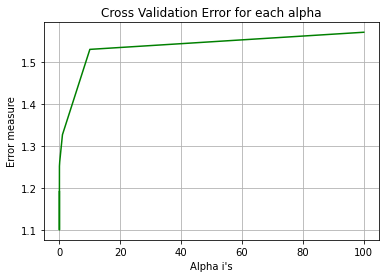

For values of best alpha =  1e-05 The train log loss is: 0.6095589527243523
For values of best alpha =  1e-05 The cross validation log loss is: 1.1005362224523754
For values of best alpha =  1e-05 The test log loss is: 1.0316836894525658


In [87]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_responseCoding,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding,y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 


plt.plot(alpha, cv_log_error_array,c='g')
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_responseCoding,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding,y_train)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))